## **Aplicação de Random Forest Regression**
Neste notebook será aplicado o modelo Random Forest Regression utilizando as features extraídas dos dados .
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA**, **ETS** e **Regressão Linear**. 

In [1]:
# confirgurando diretório
import sys
import os
sys.path.append(os.path.abspath('..'))

# importando bibliotecas
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from feature_engine.creation import CyclicalFeatures 
from src.outliers import detect_outliers
from src.features import (
    add_calendar_features, 
    add_lagged_features, 
    add_trend
)
from src.evaluation import Evaluation
from src.plots import plot_metrics, plot_time_series

# configurando notebook
tqdm.pandas()
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# configuração de estilo
sns.set_theme(context='paper')
plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'data/evaluation.csv'

## **Leitura dos Dados**

In [2]:
# leitura dos dados
train_df = pd.read_csv("data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("data/test_df.csv", parse_dates=['ds'])

In [3]:
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)


features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_calendar_features(df=x))
).reset_index(drop=True)

# outliers
features_train_df = detect_outliers(features_train_df)
features_test_df.loc[:, ['max_outliers', 'min_outliers']] = 0

In [4]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'max_outliers', 'min_outliers'],
      dtype='object')

In [5]:
# inserindo os lags nos dados de treino e teste
kwargs = {
    'features' : ['feriado', 'month_end'],
    'lags' : [-3, -2, -1, 1, 2, 3]
}

features_train_df = (
    features_train_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

features_test_df = (
    features_test_df.groupby("unique_id")
    .apply(lambda x: add_lagged_features(df=x, **kwargs))
).reset_index(drop=True)

In [6]:
features_to_encode = [
    "day",
    "week",
    "day_of_week",
    "month",
    "quarter",
]
max_values = {
    "day" : 31,
    "week" : 53,
    "day_of_week" : 6,
    "month" : 12,
    "quarter" : 4,
}
cyclical_encoder = CyclicalFeatures(
    variables     = features_to_encode,
    max_values    = max_values,
    drop_original = False
)

features_train_df = cyclical_encoder.fit_transform(features_train_df)
features_test_df = cyclical_encoder.fit_transform(features_test_df)

In [7]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'max_outliers', 'min_outliers',
       'feriado_lag-3', 'feriado_lag-2', 'feriado_lag-1', 'feriado_lag1',
       'feriado_lag2', 'feriado_lag3', 'month_end_lag-3', 'month_end_lag-2',
       'month_end_lag-1', 'month_end_lag1', 'month_end_lag2', 'month_end_lag3',
       'day_sin', 'day_cos', 'week_sin', 'week_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'quarter_sin',
       'quarter_cos'],
      dtype='object')

In [8]:
import json

with open("data/features.json", "r", encoding="utf-8") as arquivo:
    selected_features = json.load(arquivo)

## **Random Forest Regression**

In [9]:
best_models = {}

params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}


In [10]:
def run_grid_search(estimator, X, y):
    splitter = TimeSeriesSplit(n_splits=4)
    random_search = GridSearchCV(
        cv=splitter,
        estimator=estimator,
        param_grid=params,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
    )
    random_search.fit(X, y)
    return random_search.best_params_



def random_forest(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo RandomForest.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = features_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train, fcst_df = add_trend(train, fcst_df)
    
    features = selected_features[train.unique_id[0]]
    best_model = run_grid_search(
        estimator=RandomForestRegressor(),
        X=train[features], 
        y=train.y
    )
    best_models[train.unique_id[0]] = best_model
    
    # best model fit_predict
    m = RandomForestRegressor(**best_model)
    m.fit(X=train[features], y=train.y)
    fcst_df['y_pred'] = m.predict(fcst_df[features])

    return fcst_df

In [11]:
# aplicando modelo para cada série
rf_fcst = (
    features_train_df
        .groupby("unique_id")
        .progress_apply(random_forest)
        .reset_index(drop=True)
)

100%|██████████| 15/15 [09:14<00:00, 36.99s/it]


In [12]:
best_models

{'SKU_01': {'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 'SKU_02': {'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 'SKU_03': {'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 'SKU_04': {'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 'SKU_05': {'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 10,
  'n_estimators': 100},
 'SKU_06': {'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 100},
 'SKU_07': {'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 'SKU_08': {'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 100},
 'SKU_09': {'max_depth': 3,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 'SKU_10': {'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_

In [13]:
with open("data/random_forest_best_model.json", "w", encoding="utf-8") as arquivo:
    json.dump(best_models, arquivo, ensure_ascii=False, indent=4)

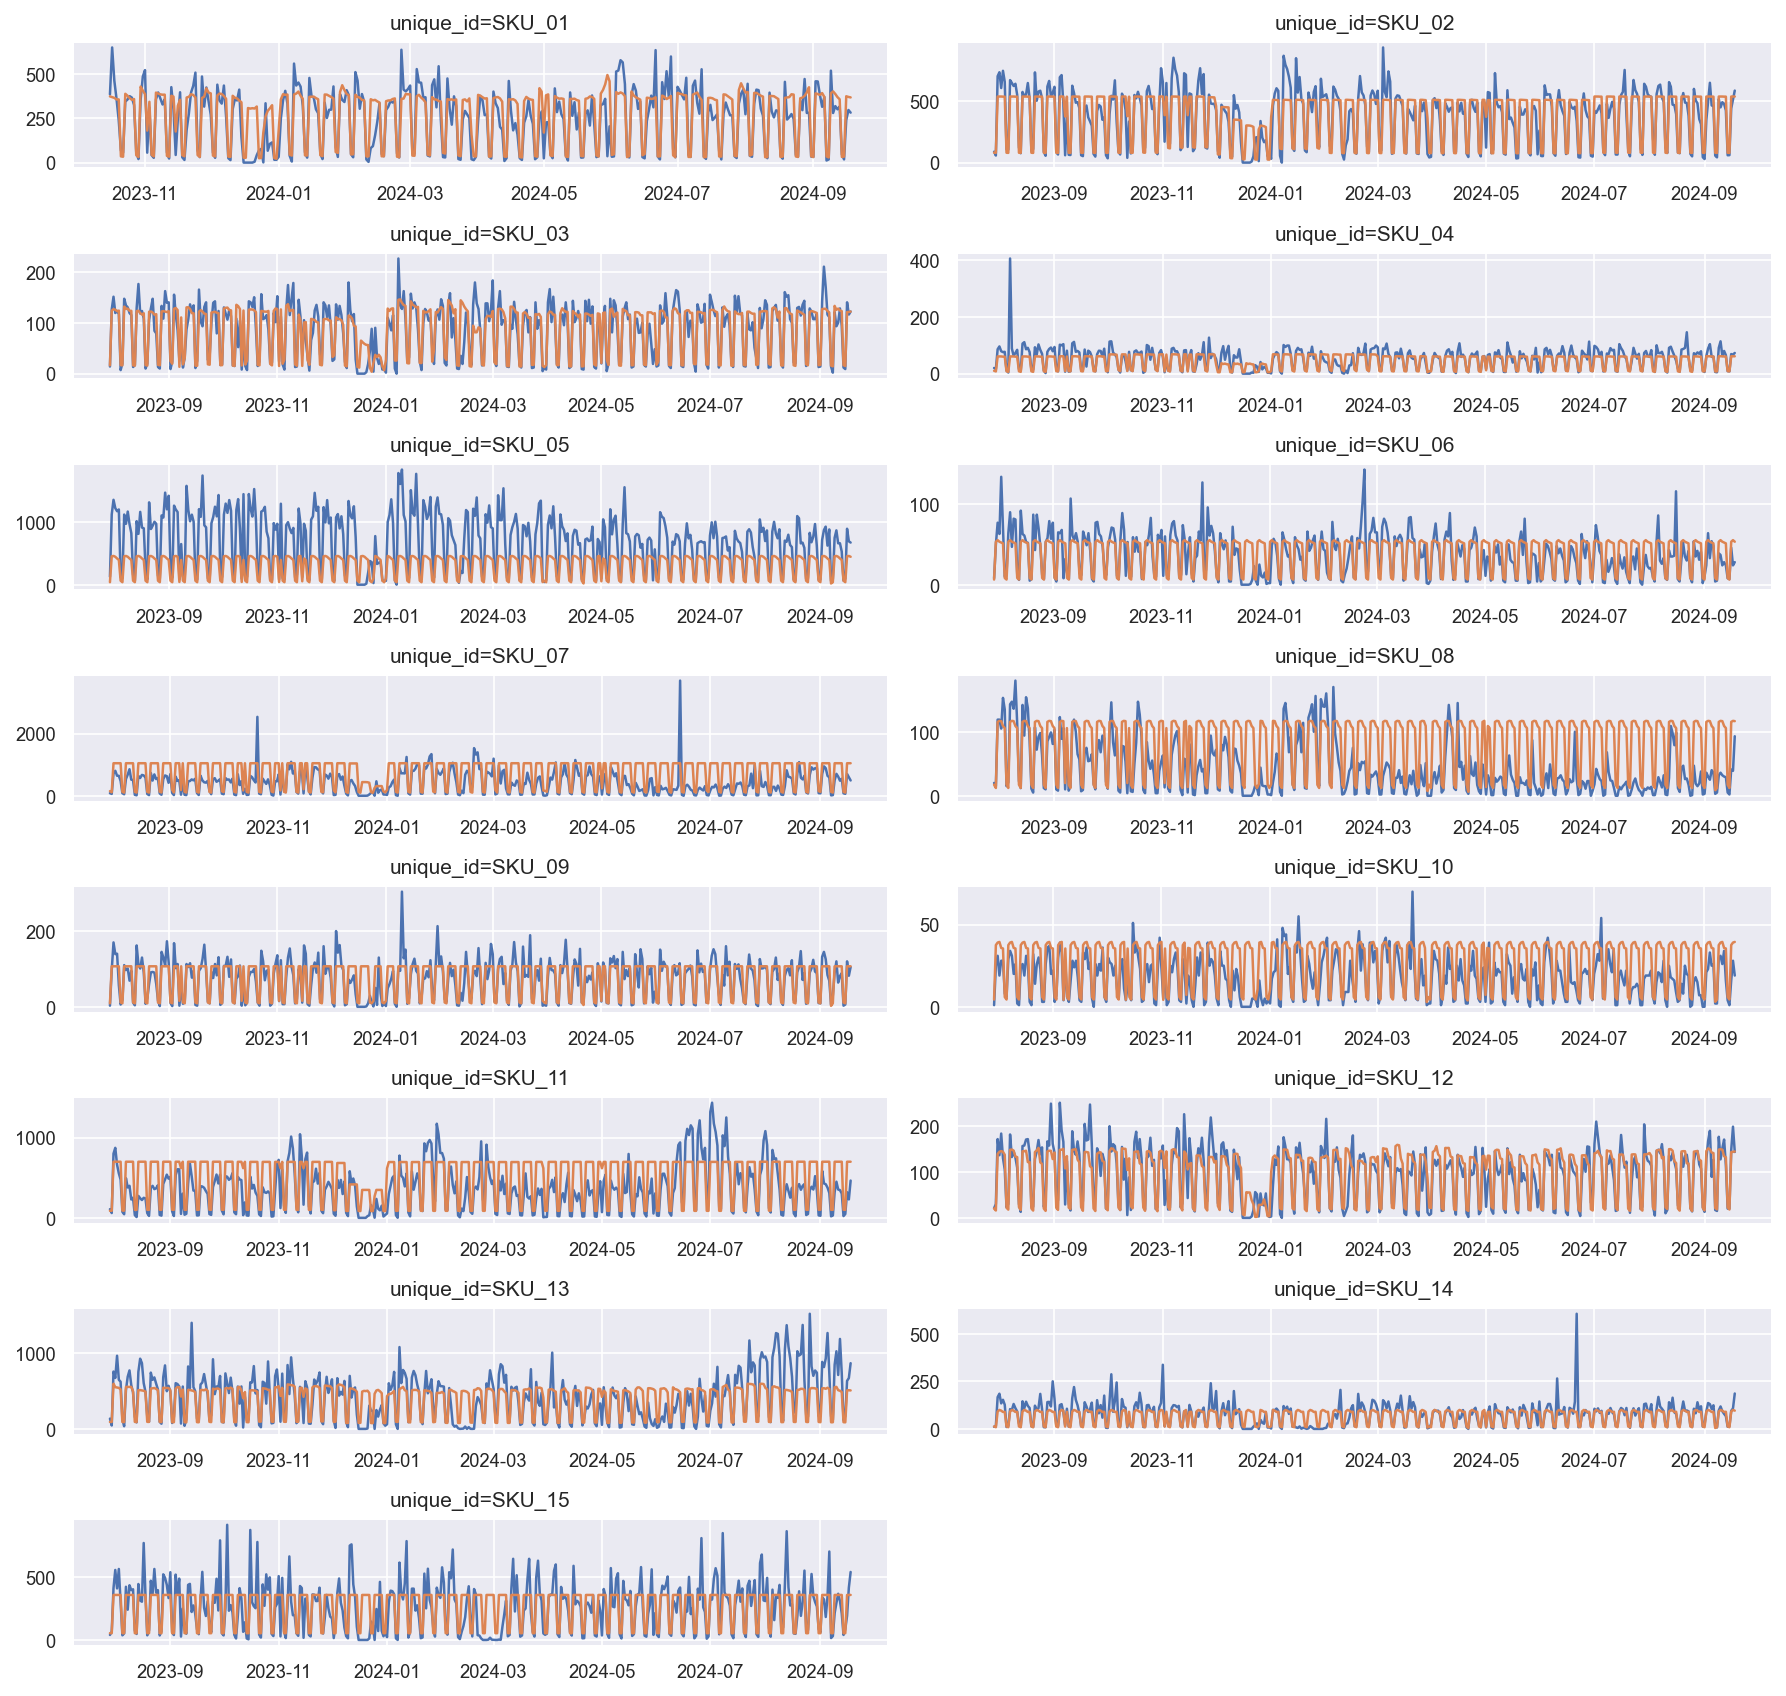

In [14]:
fig = plot_time_series(df=rf_fcst, data_cols=['y', 'y_pred'])

In [15]:
rf_eval = Evaluation(rf_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'Random Forest [+HT]')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,67.31,9272.53,96.29,0.67
SKU_02,78.81,12616.34,112.32,0.76
SKU_03,17.99,663.70,25.76,0.76
SKU_04,15.13,692.79,26.32,0.52
SKU_05,387.33,244074.65,494.04,-0.14
SKU_06,13.52,370.70,19.25,0.47
SKU_07,365.86,220099.33,469.15,-0.54
SKU_08,45.19,3256.89,57.07,-0.94
SKU_09,20.43,924.56,30.41,0.65
SKU_10,10.78,193.08,13.90,-0.21


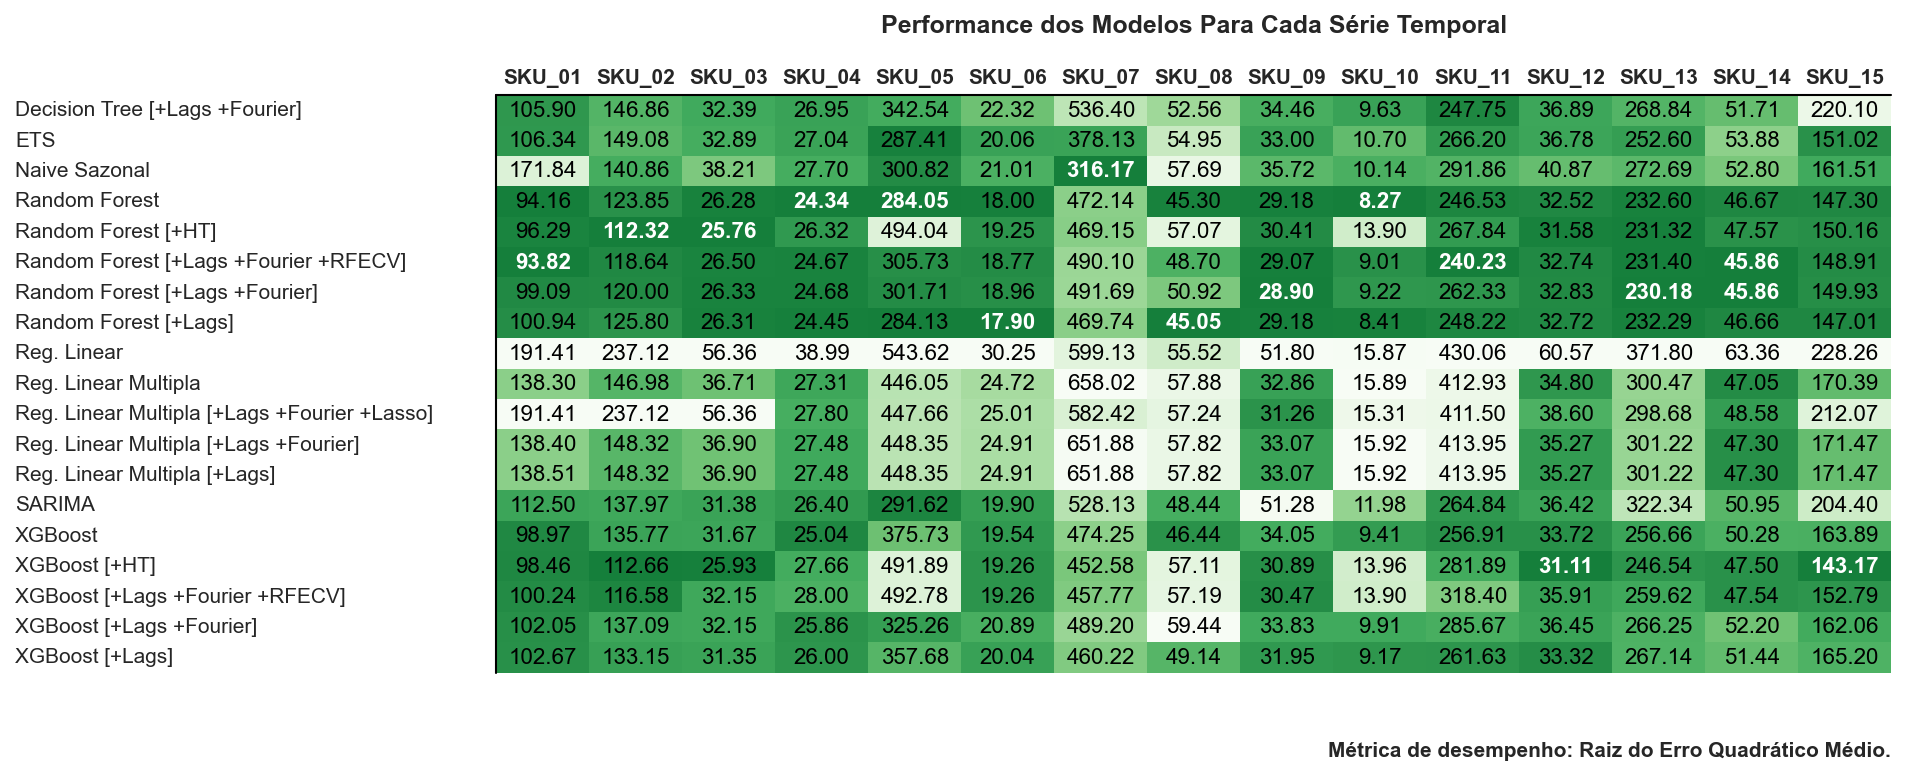

In [16]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)
order = metrics['model'].sort_values().unique()
metrics = metrics.pivot_table('rmse','unique_id','model')[order]

fig = plot_metrics(metrics, figsize=(12, 5))

In [ ]:
# selecionar modelos que possuem melhor desempenho e rodar mais vezes e armazenas as médias
# não definir a semente aleatória
# armazenar desvpad dos resultados e identificar os modelos mais estáveis
